## Homework 3
### Noah Franz
### ASTR513: Statistical Methods

Write your own Metropolis Hastings (and Gibbs) sampler. Feel free to use some of the code above:
* Choose a bivariate normal (Gaussian) distribution as the likelihood of the 2-dimensional data vector $p(D|\theta_1, \theta_2)$

$$p(D|\theta_1, \theta_2) \propto \exp \biggl( -\frac{1}{2} \underbrace{\left[ (D-M)^t \, C^{-1} \, (D-M) \right]}_{\chi^2(\theta_1, \theta_2)}  \biggr) $$
* Assume $\theta_1$ ranges from 0.1-0.5, and $\theta_2$ ranges from 0.6-1.0. The true values are $\theta_1=0.3$ and $\theta_2=0.8$
* Assume a simple mapping of the underlying parameters $\theta_1$, $\theta_2$ onto the data vector $D=(d_1,d_2)$, e.g. the simplest mapping is $d_1=\theta_1$ and $d_2=\theta_2$. Please use something slightly more complex. Note that usually the mapping of underlying parameters onto data is a complex function involving ODEs, PDEs, intergrals, interpolation routines, differentiation, etc. More importantly, each data point is usually a function of several, sometimes of all underlying parameters; there is not a 1-1 mapping of a parameter onto 1 data point (although there are transformations on the data vector that can achieve this).
* Define a conjugate, uninfromative prior (uninformative under the assumption that parameters enter linearly). Later choose more informative priors.
* Define a (co)variance matrix in data space, and play with the values of $N$ and $\rho$ (you can set both to zero at first)
$$
\begin{bmatrix}
d_1^2+N & \rho\\
\rho & d_2^2+N
\end{bmatrix}
$$

* With all this information, generate a data vector $D$ at the true values $\theta_1$ and $\theta_2$ and then sample $\theta_1$ and $\theta_2$ (using your model definition and your covariance matrix) based on a Metropolis Hastings (and Gibbs) to estimate the posterior probability.

* Repeat the above with different priors, different values for $N$ and $\rho$ in the covariance, explain what you see. Feel free to go to higher dimensions in both data and parameter space.

## Imports

In [1]:
from typing import Callable
from copy import deepcopy
import numpy as np
import scipy.stats as stats
import corner
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Setting up the MCMC

In [2]:
class Walker:
    def __init__(self, theta0:list[float]):
        '''
        The walker in the MCMC
        
        Args:
            theta0 [list[float]]: the initial position of the walker in parameter space
            targetDist [Callable]: The target distribution
        '''
        self.theta = theta0
        self.samples = []
        
    def metropolis_hastings(self, target:Callable, niters:int, burnin:int=0, sigma:float=0.1, **kwargs):
        '''
        Implements the Metropolis Hastings Algorithm and moves the walker through
        parameter space
        '''
        
        # run the MCMC with MH alg.
        naccept = 0
        c = np.diag([sigma**2]*len(self.theta))
        for ii in range(niters):
            newtheta = stats.multivariate_normal(self.theta, c).rvs()
            prob = min(target(newtheta, **kwargs)/target(self.theta, **kwargs), 1)
            if prob > np.random.rand():
                self.theta = newtheta # update the walkers position
                naccept += 1
            if ii >= burnin:
                self.samples.append(self.theta)
                
        self.acceptRate = naccept/(len(self.samples)+burnin)
        
    def gibbs(self, target:Callable, niters:int, burnin:int=0):
        '''
        Implements the Gibbs Sampling Algorithm by moving the walker
        through parameter space
        '''        
        # run the Gibbs algorithm
        for ii in range(niters):
            for jj in range(len(self.theta)):
                self.theta[jj] = target[jj]()
                if ii >= burnin:
                    self.samples.append(deepcopy(self.theta))

In [3]:
class MCMC:
    def __init__(self, target:Callable):
        '''
        Class to setup and execute an MCMC with either the Metropolis Hastings or Gibbs Methods
        
        Args:
            target [Callable]: A python function that takes in "theta" and returns the new 
                                position in parameter space based on the target distribution (likelihood*prior).
                                If this is a list, Gibbs sample will be used over Metropolis Hastings.
        '''
        self.target = target
        self.samples = None
        
    def run(self, theta0:list[float], niters:int, method:str='mh', **kwargs) -> list[list, list]:
        '''
        Method to run the MCMC algorithm
        
        Args:
            theta0 [list[float]]: the initial position of the walker
            niters [float]: The number of iterations
            method [str]: The method to use to evaluate the MCMC, can either be "mh" 
                          (for Metropolis-Hastings) or "gibbs" (for Gibbs Sampling).
                          Default is "mh".
            **kwargs are passed to the metropolis hastings or gibbs algorithms implements in Walker. 
                    Options Include:
                    Both:
                    - burnin: the number of points to throw away
                    Metropolis-Hastings:
                    - sigma: the standard distribution of the normal distribution we 
                             sample the next point from
                    
        '''
        w = Walker(theta0)
        if method == 'mh' and not isinstance(self.target, list):
            w.metropolis_hastings(self.target, niters, **kwargs)
            self.samples = w.samples
            self.acceptRate = w.acceptRate
            
        elif method == 'gibbs' and isinstance(self.target, list):
            w.gibbs(self.target, niters, **kwargs)
            self.samples = np.array(w.samples)
        else:
            raise Exception('The "method" input must be either "mh" or "gibbs"')

In [4]:
def plotSamples(samples, true=np.array([0.3,0.8]), fig=None):
    
    if not isinstance(samples, np.ndarray):
        samples = np.array(samples)
        
    fig = corner.corner(samples,
                       color='blue',
                       smooth=1,
                       labels=[r'$\theta_{}$'.format(i) for i in range(len(samples[0]))],
                       show_titles=True,
                       fig=fig
                       )
    
    corner.overplot_lines(fig, true, color="grey")
    corner.overplot_points(fig, true[None], marker="s", color="grey")

    data = mlines.Line2D([], [], color='blue', label='MCMC Samples')
    truedata = mlines.Line2D([], [], color='grey', label='Data')
    plt.legend(handles=[data,truedata], bbox_to_anchor=(0., 1.5, 1, .0), loc=4)

## General Probability Functions Used Throughout

In [5]:
# Convert from model space to data space
def model(theta):
    d1 = sum(theta)
    d2 = np.sqrt(2)*theta[1]
    return np.array([d1, d2])

In [6]:
def cov(data, N=0, rho=0):
    return np.array([[data[0]**2+N, rho],
                    [rho, data[1]**2+N]])

## Metropolis-Hastings MCMC

In [7]:
# likelihood
def lik(theta, N=0, rho=0):
    realTheta = [0.3, 0.8]
    m = model(theta)
    data = model(realTheta)
    covar = cov(data, N, rho)
    chi2 = np.array(data-m).T @ np.linalg.inv(covar) @ np.array(data-m)
    return np.exp(-0.5*chi2)

In [8]:
# prior
def prior(theta, mean=[0.3, 0.7], cov=np.array([[0.01,0],[0,0.01]])):
    
    if theta[0] < 0.1 or theta[0] > 0.5:
        return 0
    
    if theta[1] < 0.6 or theta[1] > 1:
        return 0

    return stats.multivariate_normal(mean=mean, cov=cov).pdf(theta)

In [9]:
def target(theta, **kwargs):
    return prior(theta) * lik(theta, **kwargs)

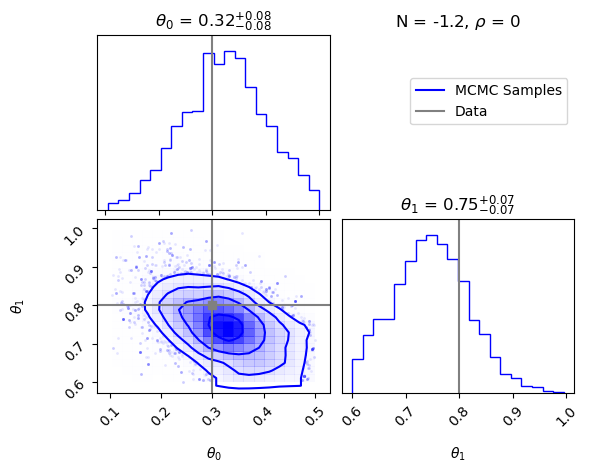

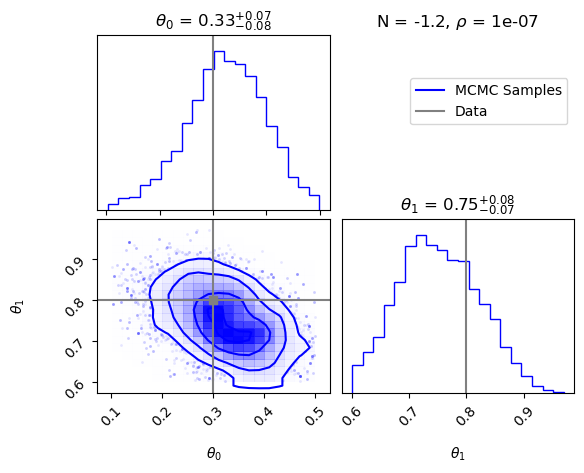

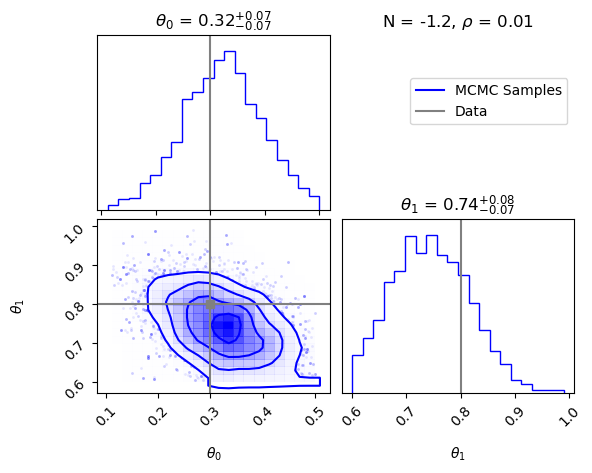

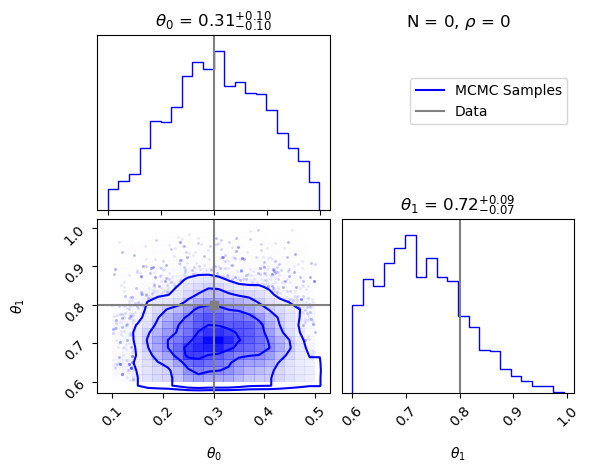

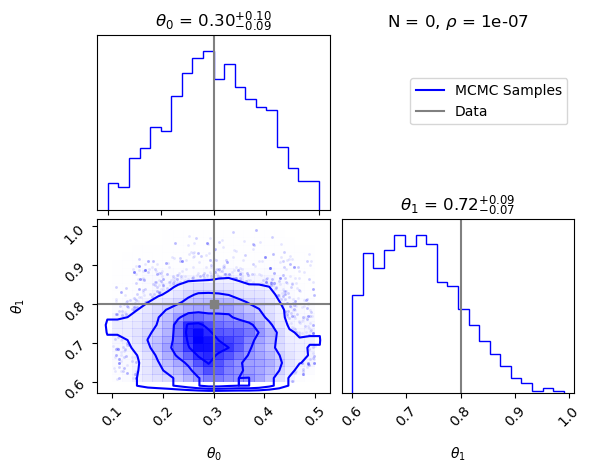

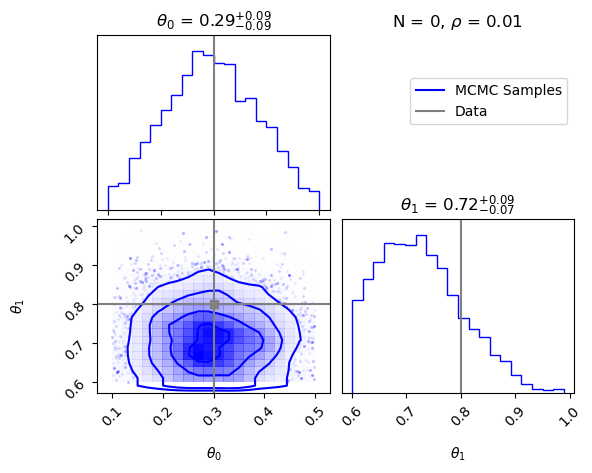

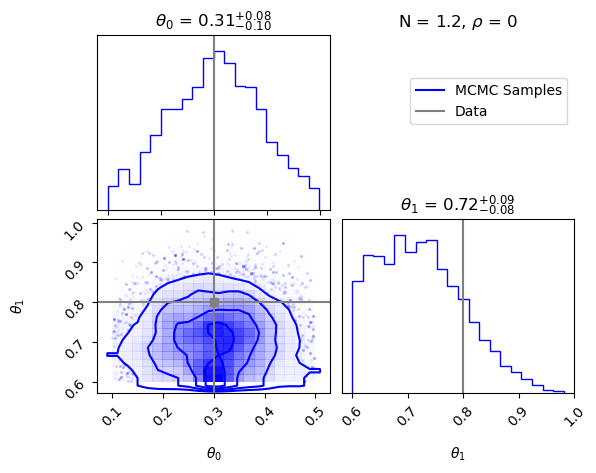

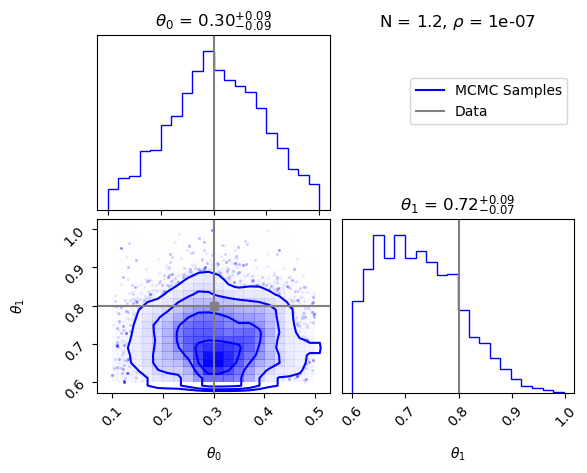

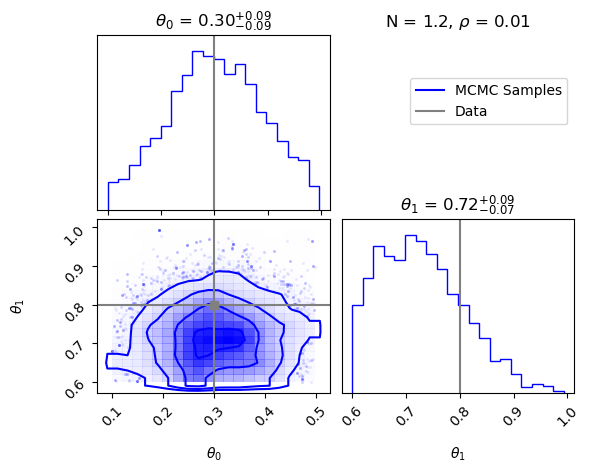

In [10]:
theta0 = np.array([0.3, 1.0])
niters = 10000
burn = int(niters/4)

# parameters to vary
Ns = [-1.2, 0, 1.2]
rhos = [0, 0.0000001, 0.01]
# run mcmc across these params

for ii, n in enumerate(Ns):
    for jj, r in enumerate(rhos):
        
        fig, ax = plt.subplots(2,2)
        ax[0,1].set_title(r'N = {}, $\rho$ = {}'.format(n, r))
        
        mcmc = MCMC(target)
        mcmc.run(theta0, niters, burnin=burn, N=n, rho=r)
        plotSamples(mcmc.samples, fig=fig)

### Comments

From the plots above it is clear that changing $N$ increases the constraining power of the likelihood function and skews the result significantly if $N$ is similar to -$data^2$. This is because if N almost cancels out $data^2$ then the diagonal of the covariance matrix is nearly 0. On the other hand, increasing $\rho$ increases the spread in the posterior which can be seen (subtly) above because increasing $\rho$ increases the other diagonal of the covariance matrix which in turn increases the relationship between $\theta_1$ and $\theta_2$. 

## Gibbs Sampling

In [11]:
means = [0.3, 0.8]
stds = [0.01, 0.01]
ranges = [(0.1, 0.5),
          (0.6, 1.0)]

def cond1():
    mean = means[0]
    std = stds[0]
    val = stats.norm(mean, std).rvs()
    out = val * (val > ranges[0][0] and val < ranges[0][1])
    while out == 0:
        val = stats.norm(mean, std).rvs()
        out = val * (val > ranges[0][0] and val < ranges[0][1])    
    return out

def cond2():
    mean = means[1]
    std = stds[1]
    val = stats.norm(mean, std).rvs()
    out = val * (val > ranges[1][0] and val < ranges[1][1])
    while out == 0:
        val = stats.norm(mean, std).rvs()
        out = val * (val > ranges[1][0] and val < ranges[1][1])    
    return out

targets = [cond1, cond2]

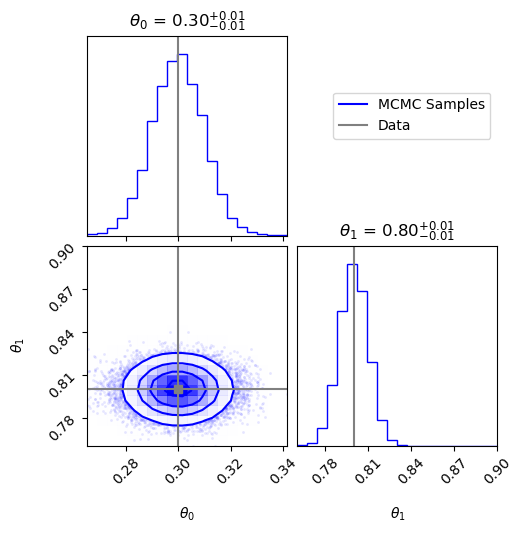

In [12]:
theta0 = np.array([0.2, 0.9])
niters = 10000

mcmc = MCMC(targets)
mcmc.run(theta0, niters, method='gibbs')
plotSamples(mcmc.samples)

### Comments
This Gibbs sampler essentially just samples from the conditional posterior distribution and accepts all points. In this case I use a gaussian conditional posterior because the analytic solution of the likelihood times the prior is in the form of a gaussian. Changing the standard deviation of the input target distribution seems to only effect the spread of the posterior.

## 4D Metropolis Hastings

In [13]:
def model4d(theta):
    d1 = sum(theta)
    d2 = np.sqrt(2)*theta[1]
    d3 = d1*2
    d4 = theta[2]+4
    return np.array([d1, d2, d3, d4])

def cov4d(data, N=0, rho=0):
    return np.array([[data[0]**2+N, rho, rho, rho],
                    [rho, data[1]**2+N, rho, rho],
                    [rho, rho, data[2]**2+N, rho],
                    [rho, rho, rho, data[3]**2+N]])

# likelihood
def lik4d(theta, N=0, rho=0):
    realTheta = [0.3, 0.8, 0, -0.15]
    m = model4d(theta)
    data = model4d(realTheta)
    covar = cov4d(data, N, rho)
    chi2 = np.array(data-m).T @ np.linalg.inv(covar) @ np.array(data-m)
    return np.exp(-0.5*chi2)

# prior
def prior4d(theta, mean=[0.3, 0.7, 0, -0.25], cov=np.diag([0.01]*4)):
    
    if theta[0] < 0.1 or theta[0] > 0.5:
        return 0
    
    if theta[1] < 0.6 or theta[1] > 1:
        return 0
    
    if theta[2] < -1 or theta[2] > 1:
        return 0
    
    if theta[3] < -0.5 or theta[3] > -0.1:
        return 0

    return stats.multivariate_normal(mean=mean, cov=cov).pdf(theta)

def target4d(theta, **kwargs):
    return prior4d(theta) * lik4d(theta, **kwargs)

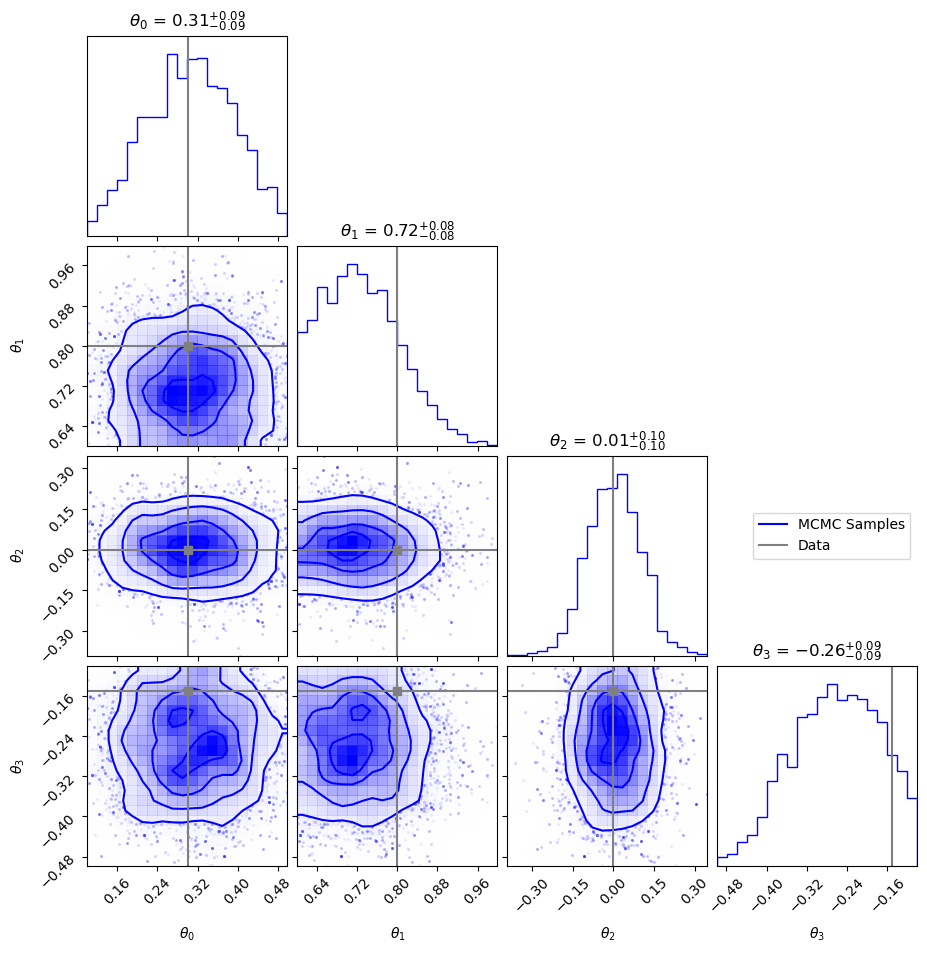

In [14]:
theta0 = np.array([0.2, 0.9, 0, -0.2])
niters = 10000

mcmc = MCMC(target4d)
mcmc.run(theta0, niters, method='mh')
plotSamples(mcmc.samples, true=np.array([0.3, 0.8, 0, -0.15]))

### Comments

This was just for fun and it worked surprisingly well! It showed me how robust the code I wrote to execute the MCMC is to an increase in dimensionality!!